# Introduction

introduce the problem of storing multidimensional array data and accessing it efficiently.

note that hdf5 is perhaps the most well-known solution, but there are newer alternatives designed from the start to integrate well with python data science pipelines.

these days, focus is also shifting to how to store and access array data on the cloud, which presents different challenges.

in this article we will compare TileDB to two python libraries for compressed, chunked array data storage and retrieval. the two libraries are bcolz and zarr.

In [11]:
%matplotlib inline

import bcolz
import matplotlib.pyplot as plt
import numcodecs
import numpy as np
import os
import shutil
import sys
import tiledb
import time
import zarr

# One-dimensional arrays

we'll start with one-dimensional data, which will help us introduce the three libraries and get some initial understanding of their relative performance.

the benchmark data will be an array of 8-byte floating point values stored initially in a numpy array. we'll use the three libraries to separately serialize the numpy array to disk.

Note that because the data is random, we don't expect to see much gain with compression by either system.

In [2]:
num_array_values = 1000
array_data = np.random.rand(num_array_values)
print('Array data is {:.2f} MB uncompressed.'.format(array_data.nbytes / (1024 * 1024.0)))

Array data is 0.01 MB uncompressed.


Next we choose names for the arrays that will be stored on disk and choose a compressor setting.

In [3]:
tiledb_array_name = 'tiledb_array'
bcolz_array_name = 'bcolz_array'
zarr_array_name = 'zarr_array'

tiledb_compressor = ('blosc-lz4', 5)
zarr_compressor = numcodecs.Blosc(cname='lz4', clevel=5)
bcolz.defaults.cparams['cname'] = 'lz4'
bcolz.defaults.cparams['clevel'] = 5

We'll define some helper functions to create persistent arrays with a given tile or chunk size, and also to remove the arrays.

TileDB has the extra step of explicitly defining an `ArraySchema` which controls the domain of the array, its dimensionality, tiling strategy, and datatypes.

In [16]:
def write_1d_tiledb_array(array_data, tile_extent):
    ctx = tiledb.Ctx()
    dom = tiledb.Domain(ctx, tiledb.Dim(ctx, domain=(0, num_array_values - 1),
                                        tile=tile_extent, dtype=np.uint32))
    schema = tiledb.ArraySchema(ctx, domain=dom, sparse=False,
                                attrs=[tiledb.Attr(ctx, name='a', dtype=np.float64, compressor=tiledb_compressor)])
    tiledb.DenseArray.create(tiledb_array_name, schema)
    with tiledb.DenseArray(ctx, tiledb_array_name, mode='w') as A:
        A[:] = array_data


def write_1d_bcolz_array(array_data, tile_extent):
    A = bcolz.carray(array_data, rootdir=bcolz_array_name, mode='w', chunklen=tile_extent)
    A.flush()


def write_1d_zarr_array(array_data, tile_extent):
    A = zarr.open(zarr_array_name, mode='w', compressor=zarr_compressor, shape=array_data.shape, chunks=(tile_extent,),
                  dtype=np.float64)
    A[:] = array_data


def remove_arrays():
    for array in [tiledb_array_name, bcolz_array_name, zarr_array_name]:
        if os.path.exists(array):
            shutil.rmtree(array)


We'll also define a helper function to time a function call a number of times.

In [7]:
def timeit(fnc, setup=None, repeat=3):
    times = []
    for i in range(0, repeat):
        if setup is not None:
            setup()
        start = time.time()
        fnc()
        end = time.time()
        times.append(end - start)
    return times

Next we'll persist the array data separately using each library and plot the minimum time over 3 iterations.

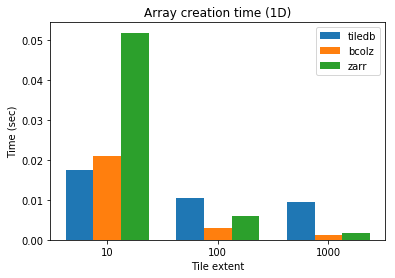

In [17]:
array_creation_times = {'tiledb': [], 'zarr': [], 'bcolz': []}
tile_extents = [10, 100, 1000]
for t_ext in tile_extents:
    array_creation_times['tiledb'].append(
        min(timeit(lambda: write_1d_tiledb_array(array_data, t_ext), setup=remove_arrays, repeat=3)))
    array_creation_times['zarr'].append(
        min(timeit(lambda: write_1d_zarr_array(array_data, t_ext), setup=remove_arrays, repeat=3)))
    array_creation_times['bcolz'].append(
        min(timeit(lambda: write_1d_bcolz_array(array_data, t_ext), setup=remove_arrays, repeat=3)))

bar_width = 0.25
xpos1 = np.arange(len(tile_extents))
xpos2 = xpos1 + bar_width
xpos3 = xpos2 + bar_width

plt.bar(xpos1, array_creation_times['tiledb'], width=bar_width, label='tiledb')
plt.bar(xpos2, array_creation_times['bcolz'], width=bar_width, label='bcolz')
plt.bar(xpos3, array_creation_times['zarr'], width=bar_width, label='zarr')

plt.title('Array creation time (1D)')
plt.xlabel('Tile extent')
plt.ylabel('Time (sec)')
plt.xticks(xpos1 + bar_width, tile_extents)

plt.legend()
plt.show()
